In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import albumentations as A
import cv2
import interpretability_toolkit.attributions as attr
import matplotlib.pyplot as plt
import timm
import torch
from albumentations.pytorch import ToTensorV2
from interpretability_toolkit.utils.plots import plot_images_heatmaps
from timm.data.constants import (
    IMAGENET_DEFAULT_MEAN,
    IMAGENET_INCEPTION_STD,
)

Attribution = attr.Attribution


c:\Users\cleme\miniconda3\envs\torch\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\cleme\miniconda3\envs\torch\Lib\site-packages\albumentations\__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.17 (you have 1.4.14). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [3]:
path = f'ClementP/FundusDRGrading-vit_base_patch14_reg4_dinov2.lvd142m'
model = timm.create_model(f'hf_hub:{path}', pretrained=True, img_size=512, num_classes=1)


In [4]:
img = cv2.imread("fundus.png")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

transform = A.Compose([A.Resize(512, 512, interpolation=cv2.INTER_CUBIC),
                       A.Normalize(IMAGENET_DEFAULT_MEAN, IMAGENET_INCEPTION_STD), ToTensorV2()])
img = transform(image=img)["image"].unsqueeze(0)


In [ ]:
model = model.cuda(0)
attr = Attribution(model, sampling_points=1024, with_replacement=False, temperature=1.2, dilate_tokens=False, 
                   attribution_method='rollout', noise_level=.0) 

img = img.cuda(0)

methods = ["attention_rollout", "chefer", 
           "focused_attention"
           ]
attributions = []
for m in methods:
    print("Generating heatmap with method: ", m)
    with torch.no_grad():
        pred = model(img)
    pred = torch.round(pred)
    head_fusion = "mean" if m == "chefer" else "min"
    with torch.autocast('cuda'):

        a = attr.attribute(img, method=m, output=pred, discard_ratio=0.5, start_from=0,
                                        as_regression=True, 
                                    head_fusion=head_fusion)
    attributions.append(torch.nan_to_num(a, nan=0.0))

fig = plot_images_heatmaps(img, attributions, border_width=3, cmap='jet', threshold='otsu', use_sigmoid=True)

plt.savefig("vit_attributions.png", bbox_inches='tight', pad_inches=0, dpi=300)


Generating heatmap with method:  attention_rollout


c:\Users\cleme\miniconda3\envs\torch\Lib\site-packages\timm\models\vision_transformer.py:92: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  x = F.scaled_dot_product_attention(


Generating heatmap with method:  chefer
Generating heatmap with method:  focused_attention


 93%|█████████▎| 13/14 [00:02<00:00,  2.89it/s]

In [6]:
path = f'ClementP/FundusDRGrading-convnext_base'
model = timm.create_model(f'hf_hub:{path}', pretrained=True, num_classes=1)


KeyboardInterrupt: 

Generating heatmap with method:  guided_gradcam
Generating heatmap with method:  ig
Generating heatmap with method:  deep_lift


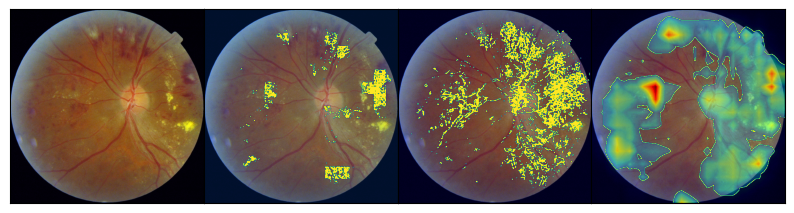

In [24]:
model = model.cuda(0)
attr = Attribution(model, sampling_points=512, with_replacement=False, temperature=1.2, dilate_tokens=False, 
                   attribution_method='rollout', noise_level=1.5) 

img = img.cuda(0)

methods = [ 
           "guided_gradcam",
           "ig", "deep_lift"
           ]
attributions = []
for m in methods:
    print("Generating heatmap with method: ", m)
    with torch.autocast('cuda'):
        a = attr.attribute(img, method=m)
        attributions.append(torch.nan_to_num(a, nan=0.0))

fig = plot_images_heatmaps(img, attributions, border_width=3, cmap='jet', threshold='otsu', use_sigmoid=False)

plt.savefig("convnext_attributions.png", bbox_inches='tight', pad_inches=0, dpi=300)
